# PINNs et EDP en 2 dimensions *(work in progress...)*

> On cherche dans ce notebook à appliquer la méthode des réseaux de neurones informés par la physique (PINNs) pour la résolution d'équations aux dérivées partielles en 2 dimensions. On implémentera la méthode en PyTorch et on reprendra quelques exemples de l'article d'Hubert Baty [1] ("A hands-on introduction to Physics-Informed Neural Networks for solving partial differential equations with benchmark tests taken from astrophysics and plasma physics", https://arxiv.org/pdf/2403.00599v1).

### Fully connected neural network

In [1]:
import torch
import torch.nn as nn
import torch.autograd as autograd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import qmc
from matplotlib import colormaps

In [2]:
class FCNN(nn.Module):
    
    def __init__(self,N_INPUT,N_OUTPUT,N_HIDDEN,N_LAYERS):
        super().__init__()
        activation=nn.Sigmoid
        self.input_layer=nn.Sequential(*[
                            nn.Linear(N_INPUT,N_HIDDEN),
                            activation()])
        self.hidden_layer=nn.Sequential(*[
                             nn.Sequential(*[
                             nn.Linear(N_HIDDEN,N_HIDDEN),
                             activation()]) for _ in range(N_LAYERS-1)])
        self.output_layer=nn.Linear(N_HIDDEN,N_OUTPUT)
        
    def forward(self,x):
        x=self.input_layer(x)
        x=self.hidden_layer(x)
        x=self.output_layer(x)
        return x

## 1) <ins>Équation de Laplace avec condition de Dirichlet</ins>

On cherche ici à retrouver des résultats comparables à l'article de Baty ([1], p.10) pour l'équation de Laplace
$$u_{xx}+u_{yy}=0.$$
La solution exacte recherchée sera la même que dans l'article, à savoir $u(x,y)=x^2-y^2.$

On appliquera ici une condition de Dirichlet aux quatre frontières d'un carré $[-1, 1]\times[-1, 1]$.

In [3]:
def init(N_bound_pts,N_colloc_pts):
    # génère : - 'N_colloc_pts' points de collocation dans un carré de taille [-1, 1] x [-1, 1]
    #          - 'N_bound_pts//4' points sur l'ensemble de la frontière de ce carré
    
    N_bound_pts=(N_bound_pts//4)*4 # assure que chaque bord du carré possède le même nombre de points 
    bound_pts=torch.zeros(N_bound_pts,2)

    a=int(N_bound_pts/4)

    sampler_2d=qmc.LatinHypercube(d=2,optimization='random-cd')
    sample_2d=torch.tensor(sampler_2d.random(n=N_colloc_pts),dtype=torch.float32)

    sampler_1d=qmc.Sobol(d=1,optimization='random-cd')
    sample_1d=torch.tensor(sampler_1d.random_base2(m=int(N_bound_pts**0.5)),dtype=torch.float32)

    colloc_pts=2*(sample_2d-0.5)
    
    # x=-1
    for i in range(0,a):
        bound_pts[i][0]=-1
        bound_pts[i][1]=2*(sample_1d[i]-0.5)
    # x=1
    for i in range(a,2*a):
        bound_pts[i][0]=1
        bound_pts[i][1]=2*(sample_1d[i]-0.5)
    # y=-1
    for i in range(2*a,3*a):
        bound_pts[i][0]=2*(sample_1d[i]-0.5)
        bound_pts[i][1]=-1
    # y=1
    for i in range(3*a,4*a):
        bound_pts[i][0]=2*(sample_1d[i]-0.5)
        bound_pts[i][1]=1   

    plt.plot([-1,1],[-1,-1],color='k',alpha=0.2)
    plt.plot([-1,1],[1,1],color='k',alpha=0.2)
    plt.plot([-1,-1],[-1,1],color='k',alpha=0.2)
    plt.plot([1,1],[-1,1],color='k',alpha=0.2)

    plt.scatter(bound_pts[:,0],bound_pts[:,1],color='r',marker='x')
    plt.scatter(colloc_pts[:,0],colloc_pts[:,1],color='darkblue',marker='.',alpha=0.6)
    plt.show()
    
    return bound_pts,colloc_pts

In [4]:
def physics_loss(model,x,y):
    # loss physique relative à l'équation de Laplace
    u=model(torch.cat((x,y),dim=1))
    
    ux=autograd.grad(u,x,create_graph=True,
                     grad_outputs=torch.ones_like(u),retain_graph=True)[0]
    uy=autograd.grad(u,y,create_graph=True,
                     grad_outputs=torch.ones_like(u),retain_graph=True)[0]
    uxx=autograd.grad(ux,x,create_graph=True,
                     grad_outputs=torch.ones_like(ux),retain_graph=True)[0]
    uyy=autograd.grad(uy,y,create_graph=True,
                     grad_outputs=torch.ones_like(uy),retain_graph=True)[0]

    return torch.mean((uxx+uyy)**2) # mean squared error

In [5]:
def data_loss(model,x,y):
    # data loss relative à la solution exacte choisie u(x,y)=x**2-y**2
    pred=model(torch.cat((x,y),dim=1))
    return torch.mean((pred-(x**2-y**2))**2)

In [6]:
def train(model,N_bound_pts,N_colloc_pts,epochs=10000,lr=5e-4):
    
    optimizer=torch.optim.Adam(model.parameters(),lr=lr)
  # scheduler=torch.optim.lr_scheduler.StepLR(optimizer,epochs//3,gamma=0.1)
    
    bound_pts,colloc_pts=init(N_bound_pts,N_colloc_pts)
    
    x_b=bound_pts[:,0].view(-1,1).requires_grad_(True)
    y_b=bound_pts[:,1].view(-1,1).requires_grad_(True)
    
    x_c=colloc_pts[:,0].view(-1,1).requires_grad_(True)
    y_c=colloc_pts[:,1].view(-1,1).requires_grad_(True)
     
    for epoch in range(epochs):
        loss=data_loss(model,x_b,y_b)+physics_loss(model,x_c,y_c)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
      # scheduler.step()
        if epoch%200==0:
            print("epoch : ",epoch,"  ---  loss = ",loss.item())
    print("epoch : ",epoch+1,"  ---  loss = ",loss.item())

In [7]:
def plot_heatmap(model):
    
    x=np.linspace(-1,1,1000)
    y=np.linspace(-1,1,1000)
    X,Y=np.meshgrid(x,y)
    
    X=torch.tensor(X.flatten(),dtype=torch.float32).view(-1,1)
    Y=torch.tensor(Y.flatten(),dtype=torch.float32).view(-1,1)
    inputs=torch.cat((X,Y),dim=1)

    model.eval()
    with torch.no_grad():
        pred=model(inputs)
        
    pred=pred.view(1000,1000).numpy()
    
    plt.imshow(pred,extent=[-1,1,-1,1],cmap='turbo',origin='lower')
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

    return pred

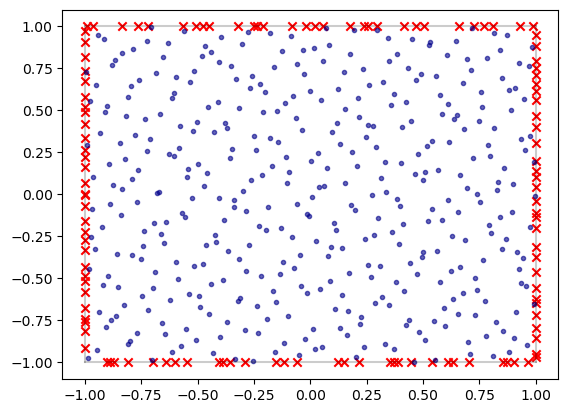

epoch :  0   ---  loss =  0.6680480241775513
epoch :  200   ---  loss =  0.5324827432632446
epoch :  400   ---  loss =  0.5320771932601929
epoch :  600   ---  loss =  0.5303344130516052
epoch :  800   ---  loss =  0.51554274559021
epoch :  1000   ---  loss =  0.3595471978187561
epoch :  1200   ---  loss =  0.11437081545591354
epoch :  1400   ---  loss =  0.00658441474661231
epoch :  1600   ---  loss =  0.0016665313160046935
epoch :  1800   ---  loss =  0.0009164297953248024
epoch :  2000   ---  loss =  0.0006501744501292706
epoch :  2200   ---  loss =  0.0004918917547911406
epoch :  2400   ---  loss =  0.00037849703221581876
epoch :  2600   ---  loss =  0.00029314946732483804
epoch :  2800   ---  loss =  0.00023020253865979612
epoch :  3000   ---  loss =  0.0001937686320161447
epoch :  3200   ---  loss =  0.00014625454787164927
epoch :  3400   ---  loss =  0.00011769497359637171
epoch :  3600   ---  loss =  9.495957056060433e-05
epoch :  3800   ---  loss =  7.693336374359205e-05
epoch 

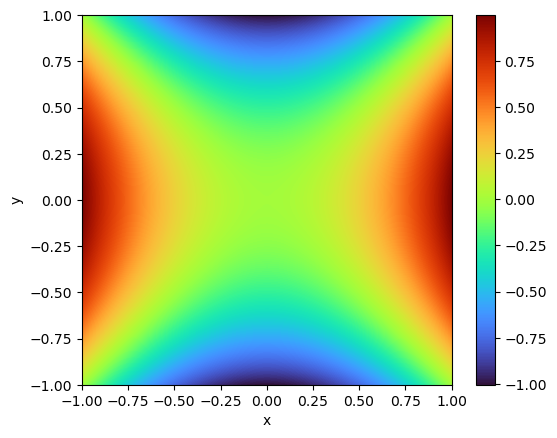

In [8]:
N_bound_pts=120
N_colloc_pts=400

epochs=10000

model=FCNN(2,1,32,3)
model.train()
train(model,N_bound_pts,N_colloc_pts,epochs)
pred=plot_heatmap(model)

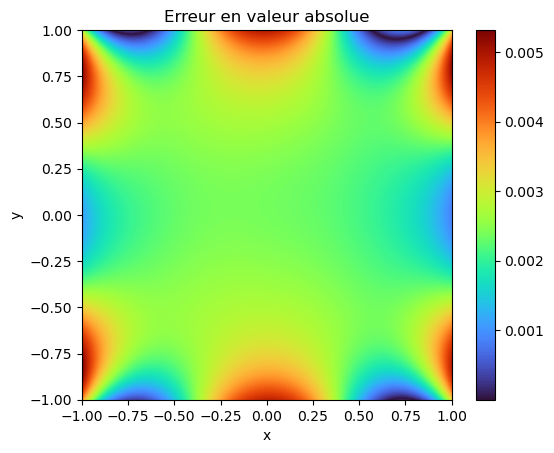

In [9]:
x=np.linspace(-1,1,1000)
y=np.linspace(-1,1,1000)
X,Y=np.meshgrid(x,y)

plt.imshow(abs(X**2-Y**2-pred),extent=[-1,1,-1,1],cmap='turbo',origin='lower')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Erreur en valeur absolue')
plt.show()

## 2) <ins>Équation de Poisson avec conditions de Dirichlet/Neumann</ins>

On reprend ici un autre exemple de l'article de Baty ([1], p.17). On cherche à résoudre par les PINNs l'équation de Poisson suivante :
$$u_{xx}+u_{yy}=e^{xy}(x^2+y^2).$$

La solution exacte choisie ici sera $u(x,y)=e^{xy}$.

Une condition de Dirichlet est appliquée sur les frontières $x=1$ et $y=1$ tandis que les frontières $x=0$ et $y=0$ possèdent une condition de Neumann. 

In [10]:
def init2(N_bound_pts,N_colloc_pts):
    # génère : - 'N_colloc_pts' points de collocation dans un carré de taille [0, 1] x [0, 1]
    #          - 'N_bound_pts//4' points sur l'ensemble de la frontière de ce carré
    
    N_bound_pts=(N_bound_pts//4)*4 # assure que chaque bord du carré possède le même nombre de points 
    bound_pts=torch.zeros(N_bound_pts,2)

    a=int(N_bound_pts/4)

    sampler_2d=qmc.LatinHypercube(d=2,optimization='random-cd')
    sample_2d=torch.tensor(sampler_2d.random(n=N_colloc_pts),dtype=torch.float32)

    sampler_1d=qmc.Sobol(d=1,optimization='random-cd')
    sample_1d=torch.tensor(sampler_1d.random_base2(m=int(N_bound_pts**0.5)),dtype=torch.float32)

    colloc_pts=sample_2d
    
    # x=0
    for i in range(0,a):
        bound_pts[i][0]=0
        bound_pts[i][1]=sample_1d[i]
    # x=1
    for i in range(a,2*a):
        bound_pts[i][0]=1
        bound_pts[i][1]=sample_1d[i]
    # y=0
    for i in range(2*a,3*a):
        bound_pts[i][0]=sample_1d[i]
        bound_pts[i][1]=0
    # y=1
    for i in range(3*a,4*a):
        bound_pts[i][0]=sample_1d[i]
        bound_pts[i][1]=1   

    plt.plot([0,1],[0,0],color='k',alpha=0.2)
    plt.plot([0,1],[1,1],color='k',alpha=0.2)
    plt.plot([0,0],[0,1],color='k',alpha=0.2)
    plt.plot([1,1],[0,1],color='k',alpha=0.2)

    plt.scatter(bound_pts[:a,0],bound_pts[:a,1],color='g',marker='x',label='Neumann')
    plt.scatter(bound_pts[a:2*a,0],bound_pts[a:2*a,1],color='r',marker='x',label='Dirichlet')
    plt.scatter(bound_pts[2*a:3*a,0],bound_pts[2*a:3*a,1],color='g',marker='x')
    plt.scatter(bound_pts[3*a:4*a,0],bound_pts[3*a:4*a,1],color='r',marker='x')
    
    plt.scatter(colloc_pts[:,0],colloc_pts[:,1],color='darkblue',marker='.',alpha=0.6)
    plt.legend(loc='center')
    plt.show()
    
    return bound_pts,colloc_pts

In [11]:
def physics_loss2(model,x,y):
    # loss physique relative à l'équation de Poisson uxx+uyy=e^{x*y}*(x**2+y**2)
    
    u=model(torch.cat((x,y),dim=1))
    
    ux=autograd.grad(u,x,create_graph=True,
                     grad_outputs=torch.ones_like(u),retain_graph=True)[0]
    uy=autograd.grad(u,y,create_graph=True,
                     grad_outputs=torch.ones_like(u),retain_graph=True)[0]
    uxx=autograd.grad(ux,x,create_graph=True,
                     grad_outputs=torch.ones_like(ux),retain_graph=True)[0]
    uyy=autograd.grad(uy,y,create_graph=True,
                     grad_outputs=torch.ones_like(uy),retain_graph=True)[0]

    return torch.mean((uxx+uyy-torch.exp(x*y)*(x**2+y**2))**2) # mean squared error

In [12]:
def loss_Dirichlet(model,x,y):
    # data loss relative à la solution exacte choisie u(x,y)=e^{xy}
    pred=model(torch.cat((x,y),dim=1))
    return torch.mean((pred-torch.exp(x*y))**2) # mean squared error

In [13]:
def loss_Neumann1(model,x,y):
    # loss des points de frontière x=0 soumis à la candition de Neumann 
    u=model(torch.cat((x,y),dim=1))
    
    uy=autograd.grad(u,y,create_graph=True,
                     grad_outputs=torch.ones_like(u),retain_graph=True)[0]

    return torch.mean((uy-x*torch.exp(x*y))**2) # mean squared error
    

def loss_Neumann2(model,x,y):
    # loss des points de frontière y=0 soumis à la candition de Neumann 
    u=model(torch.cat((x,y),dim=1))
    
    ux=autograd.grad(u,x,create_graph=True,
                     grad_outputs=torch.ones_like(u),retain_graph=True)[0]

    return torch.mean((ux-y*torch.exp(x*y))**2) # mean squared error

In [14]:
def train2(model,N_bound_pts,N_colloc_pts,epochs=10000,lr=5e-4):
    
    optimizer=torch.optim.Adam(model.parameters(),lr=lr)
  # scheduler=torch.optim.lr_scheduler.StepLR(optimizer,epochs//3,gamma=0.1)
    
    bound_pts,colloc_pts=init2(N_bound_pts,N_colloc_pts)

    a=int(N_bound_pts/4)

    # Neumann 1 : x=0
    x_n1=bound_pts[:a,0].view(-1,1).requires_grad_(True) 
    y_n1=bound_pts[:a,1].view(-1,1).requires_grad_(True) 
    # Neumann 2 : y=0
    x_n2=bound_pts[2*a:3*a,0].view(-1,1).requires_grad_(True) 
    y_n2=bound_pts[2*a:3*a,1].view(-1,1).requires_grad_(True) 
    # Dirichlet 1 : x=1
    x_d1=bound_pts[a:2*a,0].view(-1,1).requires_grad_(True)
    y_d1=bound_pts[a:2*a,1].view(-1,1).requires_grad_(True)
    # Dirichlet 2 : y=1
    x_d2=bound_pts[3*a:4*a,0].view(-1,1).requires_grad_(True)
    y_d2=bound_pts[3*a:4*a,1].view(-1,1).requires_grad_(True) 
    
    x_c=colloc_pts[:,0].view(-1,1).requires_grad_(True)
    y_c=colloc_pts[:,1].view(-1,1).requires_grad_(True)
     
    for epoch in range(epochs):
        data_loss=loss_Neumann1(model,x_n1,y_n1)  \
                 +loss_Neumann2(model,x_n2,y_n2)  \
                 +loss_Dirichlet(model,x_d1,y_d1) \
                 +loss_Dirichlet(model,x_d2,y_d2)  
        phy_loss=physics_loss2(model,x_c,y_c)
        loss=data_loss+phy_loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
      # scheduler.step()
        if epoch%200==0:
            print("epoch : ",epoch,"  ---  loss = ",loss.item())
    print("epoch : ",epoch+1,"  ---  loss = ",loss.item())

In [15]:
def plot_heatmap2(model):
    
    x=np.linspace(0,1,500)
    y=np.linspace(0,1,500)
    X,Y=np.meshgrid(x,y)
    
    X=torch.tensor(X.flatten(),dtype=torch.float32).view(-1,1)
    Y=torch.tensor(Y.flatten(),dtype=torch.float32).view(-1,1)
    inputs=torch.cat((X,Y),dim=1)

    model.eval()
    with torch.no_grad():
        pred=model(inputs)
        
    pred=pred.view(500,500).numpy()
    
    plt.imshow(pred,extent=[0,1,0,1],cmap='turbo',origin='lower')
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

    return pred

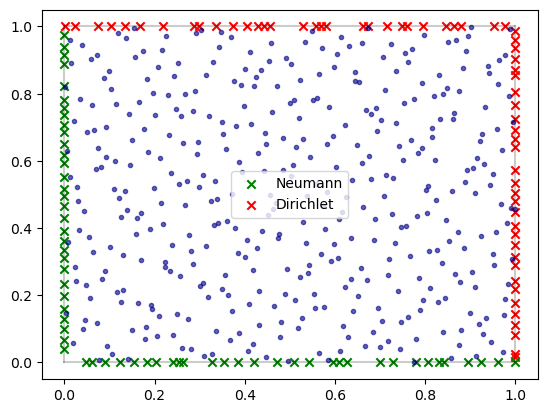

epoch :  0   ---  loss =  7.561002254486084
epoch :  200   ---  loss =  2.297785758972168
epoch :  400   ---  loss =  2.2909603118896484
epoch :  600   ---  loss =  2.2766244411468506
epoch :  800   ---  loss =  2.239391326904297
epoch :  1000   ---  loss =  2.1264331340789795
epoch :  1200   ---  loss =  1.8235526084899902
epoch :  1400   ---  loss =  1.3976962566375732
epoch :  1600   ---  loss =  0.4954039454460144
epoch :  1800   ---  loss =  0.27293065190315247
epoch :  2000   ---  loss =  0.2560788094997406
epoch :  2200   ---  loss =  0.24389955401420593
epoch :  2400   ---  loss =  0.22670873999595642
epoch :  2600   ---  loss =  0.19433051347732544
epoch :  2800   ---  loss =  0.1374226063489914
epoch :  3000   ---  loss =  0.08023285865783691
epoch :  3200   ---  loss =  0.04530080780386925
epoch :  3400   ---  loss =  0.024028873071074486
epoch :  3600   ---  loss =  0.01116582378745079
epoch :  3800   ---  loss =  0.00558099802583456
epoch :  4000   ---  loss =  0.003442734

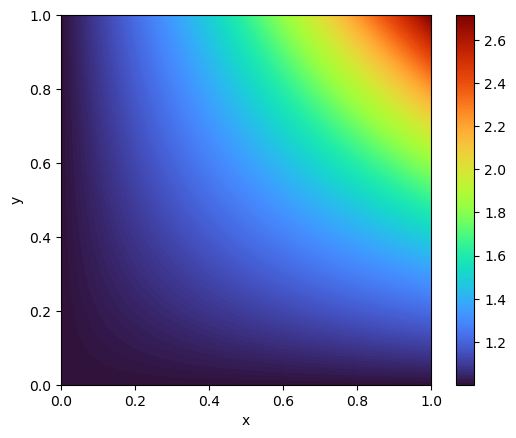

In [16]:
N_bound_pts=120
N_colloc_pts=400

epochs=10000

model2=FCNN(2,1,32,3)
model2.train()
train2(model2,N_bound_pts,N_colloc_pts,epochs)
pred2=plot_heatmap2(model2)

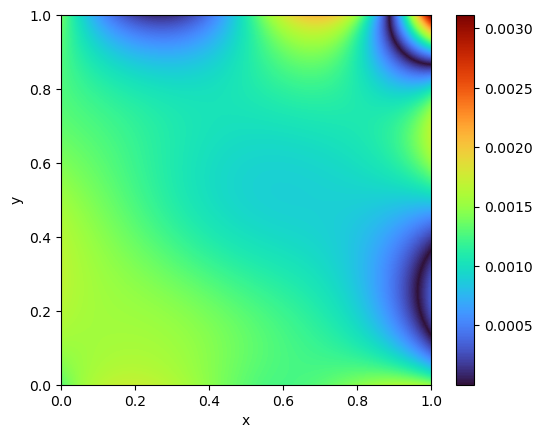

In [17]:
x=np.linspace(0,1,500)
y=np.linspace(0,1,500)
X,Y=np.meshgrid(x,y)

plt.imshow(abs(np.exp(X*Y)-pred2),extent=[0,1,0,1],cmap='turbo',origin='lower')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.show()

## 3) <ins>Équation de Grad-Shafranov</ins>